This Machine Learning Project is focused on classifying American Sign Language (ASL) hand sign. Specifically only the hands signs that represent the letters of the alphabet. The hand signs are represented in images that are retrieved from Kaggle.

Aside from just classifiying the hand signs, this project uses two distinct models to determine if neural networks or ensamble models are more accurate at classifying the hand signs.The two models being RandomForest(ensamble of decision trees) and ResNet50(neural network).

Note: GPU should be on if running this in Colab to allow ResNet50 to run faster.

In [11]:
!pip install kagglehub

In [12]:
!pip install "numpy<2" opencv-python mediapipe

In [4]:
import kagglehub
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import os
import string
# path = kagglehub.dataset_download("danrasband/asl-alphabet-test")
path = kagglehub.dataset_download("grassknoted/asl-alphabet")

print("Path to dataset files:", path)

# root = os.path.join(path, "asl_dataset/asl_alphabet_train")
root = os.path.join(path, "asl_alphabet_train/asl_alphabet_train")
print("Using dataset root:", root)

print("Root path:", root)
print("\nFolders inside dataset:")
print(os.listdir(root))

letters_only = [folder for folder in os.listdir(root) if folder in string.ascii_uppercase]

print("\nLetters only folders inside dataset:")
print(letters_only)

C:\Users\mckon\miniconda3\envs\cs345\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\mckon\.cache\kagglehub\datasets\grassknoted\asl-alphabet\versions\1
Using dataset root: C:\Users\mckon\.cache\kagglehub\datasets\grassknoted\asl-alphabet\versions\1\asl_alphabet_train/asl_alphabet_train
Root path: C:\Users\mckon\.cache\kagglehub\datasets\grassknoted\asl-alphabet\versions\1\asl_alphabet_train/asl_alphabet_train

Folders inside dataset:
['A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'nothing', 'O', 'P', 'Q', 'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

Letters only folders inside dataset:
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


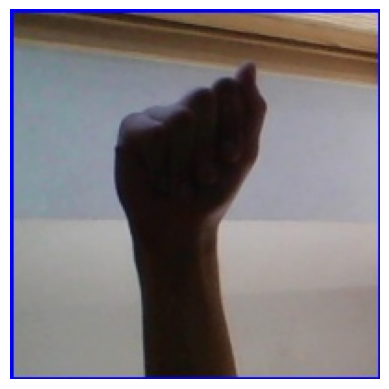

In [5]:
class_folder = os.path.join(root, "A")
# print(class_folder)
# Pick the first image
img_path = os.path.join(class_folder, os.listdir(class_folder)[0])

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis("off")
plt.show()


**Pre-processing - labeling images**

Each folder is labeled, which is the basis for the label of each image below.

In [ ]:
IMG_SIZE = 64

X = []
y = []

for label in os.listdir(root):
    class_folder = os.path.join(root, label)

    if label not in string.ascii_uppercase:
      continue

    if not os.path.isdir(class_folder):
        continue

    for img_name in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_name)

        img = cv2.imread(img_path)
        if img is None:
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        X.append(img.flatten())
        y.append(label)
X = np.array(X)
y = np.array(y)

print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)

**RandomForest configuration and processing**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

rfc = RandomForestClassifier(n_estimators=100, random_state=42)

rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.2f}")

**ResNet50 configuration and processing**

For the processing of ResNet50, we start by training it on the Kaggle dataset and do not use the pretrained weights to classify the imaages. This is because we want to determine how well the model compares to RandomForest and using added weights gives ResNet50 an unfair advantage.

In [18]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

if tf.config.list_physical_devices('GPU'):
  device = "GPU"
else:
  device = "CPU"

print(f"Using {device} device")

# 1 Channel because we are using greyscale
# ResNet50 expects image size 224, 224, but using 64 for consitency and speed to train
IMAGE_SIZE = [64, 64, 1]
PIXEL = 64

X_shaped = X.reshape(-1,PIXEL,PIXEL,1)/255

encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(np.array(y).reshape(-1,1))

X_train, X_test, y_train, y_test = train_test_split(X_shaped, y_encoded, test_size=.2, random_state=42)

# Number of Passes
EPOCHS = 20

input = Input(shape=IMAGE_SIZE)

# No weights means no pretrained data
base_ResNet = ResNet50(weights=None, include_top=False, input_shape=IMAGE_SIZE, input_tensor=input)

# Uncomment to see training model details
# print(base_ResNet.summary())

X_RN = base_ResNet.output
X_RN = GlobalAveragePooling2D()(X_RN)
X_RN = Flatten()(X_RN)

predictions = Dense(26, activation='softmax')(X_RN)
model = Model(inputs=base_ResNet.input, outputs=predictions)

# Adam helps to control the learning process
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_split=0.2)

result = model.evaluate(X_test, y_test)
print ("Loss = " + str(result[0]))
print ("Test Accuracy = " + str(result[1]))

Using GPU device
Epoch 1/20
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 84s 23ms/step - accuracy: 0.3415 - loss: 2.2105 - val_accuracy: 0.7094 - val_loss: 0.8923
Epoch 2/20
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - accuracy: 0.8224 - loss: 0.4952 - val_accuracy: 0.8227 - val_loss: 0.5983
Epoch 3/20
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.9176 - loss: 0.2415 - val_accuracy: 0.8731 - val_loss: 0.3845
Epoch 4/20
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.9455 - loss: 0.1634 - val_accuracy: 0.9667 - val_loss: 0.0975
Epoch 5/20
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.9589 - loss: 0.1263 - val_accuracy: 0.9187 - val_loss: 0.2384
Epoch 6/20
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.9727 - loss: 0.0842 - val_accuracy: 0.9255 - val_loss: 0.2140
Epoch 7/20
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.9780 - loss: 0.0706 - val_accuracy: 0.9300 - val_loss: 0.2950
Epoch 8/20
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - a

**Reasources and Sources**

For general understanding of ResNet arguments to use: https://keras.io/api/applications/resnet/

Understanding Adam Optimizer: https://www.geeksforgeeks.org/deep-learning/adam-optimizer/


https://www.geeksforgeeks.org/dsa/random-forest-classifier-using-scikit-learn/

General help understanding ResNet50: https://www.geeksforgeeks.org/computer-vision/image-classification-using-resnet/

Tutorial of using ResNet50 for detecting aliens and preditors as images: https://www.youtube.com/watch?v=5SJAPmQy7xs&t=2s

Example processing with ResNet50: https://github.com/priya-dwivedi/Deep-Learning/blob/35a3ea2842eaa4a194a19f95436294a0a38cdc72/resnet_keras/Residual_Network_Keras.ipynb#L86